In [62]:
import numpy as np
import pandas as pd
from IPython.display import Image
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

In [63]:
#激活函数
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

def relu(Z):
    A = np.maximum(0,Z)
    return A
 
def sigmoid_backward(dA, Z):
    """
     实现了sigmoid单元的反向传播
    
    dA -- 损失函数对A的梯度
    Z -- 带权输入Z
    Returns:
    dZ -- 损失函数对Z的梯度
    """
    s = sigmoid(Z)
    dZ = dA * s * (1-s) # dA乘sigmoid导数
    return dZ

def relu_backward(dA, Z):
    """
    实现了relu单元的反向传播

    dA -- 损失函数对A的梯度
    Z -- 带权输入Z
    Returns:
    dZ -- 损失函数对Z的梯度
    """
    dZ = np.array(dA, copy=True) # relu导数为1(输入大于0)，所以直接复制一份dA即可
    dZ[Z <= 0] = 0 # 当输入小于0时，relu导数为0，所以dZ中小于0的数变为0
    return dZ


In [64]:
#初始化参数
def init_layers(nn_architecture, seed = 99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        if idx == len(nn_architecture):
            break
        layer_idx = idx + 2
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1

    return params_values



In [65]:
#前向传播的函数
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="sigmoid"):
    """
    A_prev -- 上一层的输出
    W_curr -- 这一层的权重矩阵
    b_curr -- 这一层的偏移向量
    Returns:
    A_curr -- 这一层的输出
    Z_curr -- 这一层的带权输入
    """
    Z_curr = np.dot(W_curr, A_prev) + b_curr

    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
    
    A_curr = activation_func(Z_curr)
    return A_curr, Z_curr

def full_forward_propagation(X, params_values, layer_dims):
    memory = {}  # 存储中间层A和Z矩阵的值
    A_curr = np.transpose(X)

    for idx, layer in enumerate(layer_dims):
        if idx == len(nn_architecture):
            break
        layer_idx = idx + 2
        A_prev = A_curr

        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, 'sigmoid')

        memory["A" + str(idx+1)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr

    return A_curr, memory

In [66]:
#损失函数
def compute_cost(Y_pred, Y):
 #交叉熵损失函数
    m = Y_pred.shape[1]
    cost = -1 / m * (np.dot(Y, np.log(Y_pred).T) + np.dot(1 - Y, np.log(1 - Y_pred).T))
    return np.squeeze(cost)


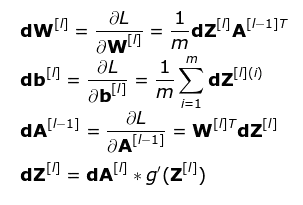

In [67]:
Image(filename = '反向传播.png', width=320, height=260)

In [68]:
#反向传播
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    """
    dA_curr -- 损失函数对当前层的输出A的梯度
    W_curr -- 这一层的权重矩阵
    b_curr -- 这一层的偏移向量
    Z_curr -- 这一层的带权输入
    A_prev -- 上一层的输出
    Returns:
    dA_prev -- 损失函数对上一层输出的梯度
    dW_curr -- 损失函数对这一层权重矩阵的梯度
    db_curr -- 损失函数对这一层偏移向量的梯度
    """
    m = A_prev.shape[1]
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')

    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

In [69]:

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    """
    Y_hat -- 预测值
    Y -- 真实值
    memory -- 存储上一层的输出A_prev和这一层的带权输入Z_curr
    params_values -- 参数值（权重矩阵和偏移向量）
    nn_architecture -- 网络结构
    Returns:
    grads_values -- 损失函数对这一层W和b的梯度值
    """

    grads_values = {}
    Y = Y.reshape(Y_hat.shape)

    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));

    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_prev = layer_idx_prev + 1
        layer_idx_curr  = layer_idx_prev +1
        activ_function_curr = layer["activation"]

        dA_curr = dA_prev

        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]

        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr

    return grads_values

In [70]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    """
    params_values -- 更新前的参数值（W和b）
    grads_values -- W和b的梯度值
    nn_architecture -- 网络结构
    learning_rate -- 学习率
    Returns:
    params_values -- 更新后的参数值
    """
    for layer_idx, layer in enumerate(nn_architecture):
        if layer_idx == len(nn_architecture):
            break
        layer_idx = layer_idx +2
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values

In [74]:
def train(X, Y, nn_architecture, epochs, learning_rate):
    """
    X -- 输入X
    Y -- 标签真实值Y
    nn_architecture -- 网络结构
    epochs -- 迭代次数
    Returns:
    params_values -- 训练后的参数值（W和b）
    cost_history -- 损失
    accuracy -- 准确率
    """
    params_values = init_layers(nn_architecture, 2)
    cost_history = []
    accuracy_history = []

    for i in range(epochs):
        Y_hat, cache = full_forward_propagation(X, params_values, nn_architecture)
        cost = compute_cost(Y_hat, Y)
        cost_history.append(cost)
        if i %500 ==0:
            print("cost %f of %d epoch"%(cost,i))
        #accuracy = get_accuracy_value(Y_hat, Y)
        #accuracy_history.append(accuracy)

        grads_values = full_backward_propagation(Y_hat, Y, cache, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)

    return params_values, cost_history, accuracy_history

In [75]:
nn_architecture = [
    {"input_dim": 4, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 3, "activation": "relu"},
    {"input_dim": 3, "output_dim": 1, "activation": "sigmoid"},
]
iris = datasets.load_iris()
X= iris['data']
y = iris['target']
X = X[y!=2]
y=y[y!=2]
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state = 4)
params_values, cost_history, accuracy_history = train(X_train,y_train,nn_architecture, 10000, 0.3)

cost 0.693043 of 0 epoch:
cost 0.678875 of 500 epoch:
cost 0.305129 of 1000 epoch:
cost 0.118128 of 1500 epoch:
cost 0.075532 of 2000 epoch:
cost 0.049896 of 2500 epoch:
cost 0.040224 of 3000 epoch:
cost 0.031288 of 3500 epoch:
cost 0.023143 of 4000 epoch:
cost 0.019122 of 4500 epoch:
cost 0.016565 of 5000 epoch:
cost 0.015014 of 5500 epoch:
cost 0.013462 of 6000 epoch:
cost 0.012598 of 6500 epoch:
cost 0.012004 of 7000 epoch:
cost 0.011542 of 7500 epoch:
cost 0.010892 of 8000 epoch:
cost 0.010584 of 8500 epoch:
cost 0.010026 of 9000 epoch:
cost 0.009496 of 9500 epoch:


In [86]:
y_pred,memory = full_forward_propagation(X_test,params_values,nn_architecture)

In [92]:
y_pred

array([[1.91851249e-02, 3.59494684e-05, 9.92017339e-01, 2.58898273e-06,
        9.92044061e-01, 2.87642047e-01, 9.92021986e-01, 9.92029852e-01,
        4.14615718e-01, 3.24735025e-04, 2.54602869e-03, 7.10882739e-05,
        9.91999203e-01, 3.95430006e-03, 1.45342426e-05, 1.33940430e-05,
        1.24631148e-06, 1.41022423e-02, 2.24857597e-05, 9.92070409e-01,
        9.91986664e-01, 1.67217009e-05, 9.91969265e-01, 9.92061372e-01,
        9.92064310e-01, 9.91960783e-01, 1.96504268e-04, 9.92098204e-01,
        9.92028080e-01, 1.80991116e-05]])

In [90]:
preds_01 = np.where(y_pred>0.5,1,0)
preds_01 = preds_01.flatten()
preds_01

array([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0])

In [91]:
print("测试数据准确率:",accuracy_score(preds_01, y_test))

测试数据准确率: 1.0
